# Chapter8 : Generative Deep Learning

## 8.4 Generating images with variational autoencoders

Sampling from a latent space of images to create entirely new images or edit existing ones is currently the most popular and successful applications of creative AI.

In this section and the next, we'll review some high-level concepts pretraining to image generation, alongside implementation details relative to the two main techniques in this domain: *variational autoencoders* (VAEs) and *generative adversarial networks* (GANs). The techniques we present here aren't specific to images--you could develop latent spaces of sound, music, or even text, using GANs and VAEs--but in practice, the most interesting results have been obtained with pictures, and that's what we focus on here.

### 8.4.1 Sampling from latent spaces of images

The key idea of image generation is to develop a low-dimensional *latent space* of representations where any point can be mapped to a realistic-looking image. The module capable of realizing this mapping, taking as input a latent point and outputting an image, is called ***generator*** (in the case of GANs) or a ***decoder*** (in the case of VAEs).

Once such a latent space has been developed, you can sample points from it, either deliberately or at random, and, by mapping them to image space, generate images that have never been seen before.

<img src="image/fig89.PNG" width='500'>

GANs and VAEs are two different strategies for learning such latent spaces of image representations, each with its own characteristics.

VAEs are great for learning latent spaces that are well structured, where specific directions encode a meaningful axis of variation in the data.

GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuity.

### 8.4.2 Concept vectors for image editing

Given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data. In the latent space of images of faces, for instance, there may be *smile vectors*, such that if latent point `z` is the embedded representation of the same face, then latent point `z + s` is the embdedded representation of the same face, smiling. Once you've identified such a vector, it then becomes possible to edit images by projecting them into the latent space, moving their representation in a meaningful way, and then decoding them back to image space. There are concept vectors for essentially any independent dimension of variation in image space--in the case of faces, you may discover vectors for adding sunglasses to a face, removing glasses, turning a male face into a female face, and so on.

<img src='image/fig811.PNG' width='500'>

### 8.4.3 Variational autoencoders

Variational autoencoders are a kind of generative model that's especially appropriate for the task of image editing via concept vectors.

A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module. It's then trained by using as target data the *same images* as the input images, meaning the **autoencoder learns to reconstruct the original inputs**. Most commonly, you'll constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

<img src='image/fig812.PNG' width='500'>

In practice, such classical autoencoders don't lead to particularly useful or nicely structured latent spaces. 

VAEs, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution: a mean and a variance. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

<img src='image/fig813.PNG' width='500'>

In technical terms, here's how a VAE works:
  1. An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
  2. You randomly sample a point `z` from the latent normal distribution that's assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values.
  3. A decoder module maps this point in the latent space back to the original input image.

Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: a ***reconstruction loss*** that forces the decoded sample to match the initial inputs, and a ***regularization loss*** that helps learn well-formed latent spaces and reduce overfitting to the training data.

#### VAE encoder network

The following listing shows the encoder network you'll use, mapping images to the parameters of a probability distribution over the latent space.

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [0]:
img_shape = (28, 28, 1)
batch_size = 16
# dimensionality of the latent space: a 2D plane
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# the input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

#### Latent-space-sampling function

Here, you wrap some arbitrary code into a `Lambda` layer. In Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or in a custom layer).

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0, stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

#### VAE decoder network, mapping latent space points to images

The following listing shows the decoder implementation. You reshape the vector `z` to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the origiinal `input_img`.

In [0]:
# input where you'll feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshapes z into a feature map of the same shape 
# as the feature map just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# uses a Conv2DTranspose layer and Conv2D layer to decode z into a feature map
# the same size as the original image input
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

# instantiates the decoder model, 
# which turns 'decoder_input' into the decoded image
decoder = Model(decoder_input, x)

# applies it to z to recover the decoded z
z_decoded = decoder(z)

#### Custom layer used to compute the VAE loss

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, you'll set up the loss by writing a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss.

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

#### Training the VAE

Finally, you're ready to instantiate and train the model.

In [6]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [7]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None),
        verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 32s - loss: 0.2114 - val_loss: 0.1978
Epoch 2/10
 - 26s - loss: 0.1929 - val_loss: 0.1895
Epoch 3/10
 - 26s - loss: 0.1887 - val_loss: 0.1870
Epoch 4/10
 - 26s - loss: 0.1863 - val_loss: 0.1872
Epoch 5/10
 - 26s - loss: 0.1847 - val_loss: 0.1845
Epoch 6/10
 - 26s - loss: 0.1834 - val_loss: 0.1820
Epoch 7/10
 - 26s - loss: 0.1825 - val_loss: 0.1824
Epoch 8/10
 - 27s - loss: 0.1817 - val_loss: 0.1833
Epoch 9/10
 - 26s - loss: 0.1810 - val_loss: 0.1822
Epoch 10/10
 - 25s - loss: 0.1805 - val_loss: 0.1810


#### Sampling a grid of points from the 2D latent space and decoding them to images

In [0]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [11]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

In [12]:
grid_y

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

In [0]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

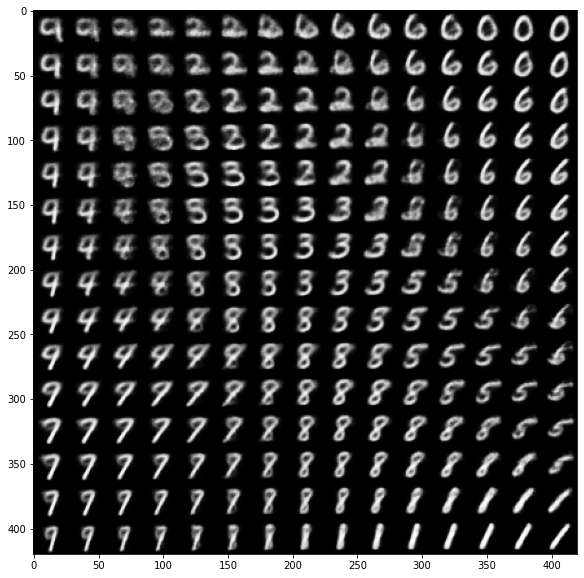

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning: for example, there's a direction for "four-ness", "one-ness", and so on.